## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-03-02 17:29:17--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  2.87MB/s    in 2.0s    

2025-03-02 17:29:19 (2.87 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any

In [1]:
import pandas as pd
import numpy as np
from typing import Union

In [2]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [3]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [4]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [5]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [6]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [7]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [8]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    users_cnt = df.user_id.max() + 1
    items_cnt = df.item_id.max() + 1

    res = np.empty(shape=(users_cnt, items_cnt))  # Инициализируем np.ndarray
    res[df.user_id.values, df.item_id.values] = df.rating.values  # Заполняем его
    
    return res

In [9]:
interactions = df_to_matrix(df_train)

In [10]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:
    users_cnt = df.user_id.max() + 1
    items_cnt = df.item_id.max() + 1
    
    return coo_array(
        arg1=(df.rating.values, (df.user_id.values, df.item_id.values)),  # coo_array((data, coords), [shape])
        shape=(users_cnt, items_cnt), 
        dtype=float
    )

In [11]:
coo_interactions = df_to_coo(df_train)

In [12]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [13]:
from scipy.linalg import svd
from scipy.sparse.linalg import svds
from scipy.sparse._coo import coo_array as scipy_coo_array

In [14]:
def make_svd(
    interractions: Union[np.ndarray, coo_array], 
    n_singular_values: int = -1
):
    if isinstance(interractions, np.ndarray):
        U, S, V = svd(interactions, full_matrices=False)
        if n_singular_values != -1:
            U, S, V = U[:, :n_singular_values], S[:n_singular_values], V[:n_singular_values, :]

    if isinstance(interractions, scipy_coo_array):
        rank_param = min(n_users, n_items) - 1 if n_singular_values == -1 else n_singular_values
        U, S, V = svds(
            interractions,
            k=rank_param
        )
        
        sorted_indices = np.argsort(S)[::-1]
        U, S, V = U[:, sorted_indices], S[sorted_indices], V[sorted_indices, :]
    
    return U, np.diag(S), V

In [15]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [16]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [17]:
def make_svd_recommendations(
    interractions: Union[np.ndarray, coo_array], 
    n_singular_values: int = -1, 
    top_k: int = 100
):
    U, S, V = make_svd(interractions, n_singular_values)
    items_cnt = interractions.shape[1]
    y_pred = U @ S @ V

    if isinstance(interractions, np.ndarray):
        interactions_array = interractions
    if isinstance(interractions, scipy_coo_array):
        interactions_array = interractions.toarray()

    rec_matrix = np.where(
        interactions_array == 0,
        y_pred,
        -np.inf
    )

    last_k = items_cnt - top_k - 1  # np.argsort is ascending
    return rec_matrix.argsort()[:, :last_k:-1]

In [18]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [44]:
from scipy.sparse import csr_matrix

In [45]:
import time
import matplotlib.pyplot as plt

In [49]:
def ndcg_metric(
    interactions: Union[np.ndarray, coo_array], 
    recs
) -> float:
    users_cnt, top_k = recs.shape
    ndcg_scores = []

    for user_id in range(users_cnt):
        if isinstance(interactions, np.ndarray):
            interactions_array = interactions[user_id, :]
        elif isinstance(interactions, scipy_coo_array):
            interactions_array = csr_matrix(interactions).getrow(user_id).toarray()[0,:]
        items_pred = interactions_array[recs[user_id, :]]

        if np.any(interactions_array != 0):
            dcg_score = np.sum((2**items_pred - 1) / np.log2(np.arange(top_k) + 2))
            idcg_score = np.sum((2**np.sort(items_pred)[::-1] - 1) / np.log2(np.arange(top_k) + 2))
            ndcg_score = dcg_score / idcg_score if idcg_score > 0 else 0.
            ndcg_scores.append(ndcg_score)
    
    return np.mean(ndcg_scores)

In [60]:
def plot_graphs(
    interactions_train: Union[np.ndarray, coo_array], 
    interactions_test: Union[np.ndarray, coo_array], 
    top_k: int = 100
):
    n_singular_values_arr = np.round(np.linspace(1, 10**3, 10)).astype(int)
    ndcg_scores = []
    times = []

    for n_singular_values in n_singular_values_arr:
        start_time = time.time()
        cur_recs = make_svd_recommendations(
            interactions_train, 
            n_singular_values, 
            top_k
        )
        end_time = time.time()

        ndcg_scores.append(ndcg_metric(interactions_test, cur_recs))
        times.append(end_time - start_time)

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    ax[0].plot(n_singular_values_arr, ndcg_scores)
    ax[0].set_title("NCDG metric by n_singular_values")
    ax[0].set_xlabel("n_singular_values")
    ax[0].set_ylabel("NCDG metric")

    ax[1].plot(n_singular_values_arr, times)
    ax[1].set_title("Time to fit by n_singular_values")
    ax[1].set_xlabel("n_singular_values")
    ax[1].set_ylabel("Time to fit, seconds")

    plt.show()

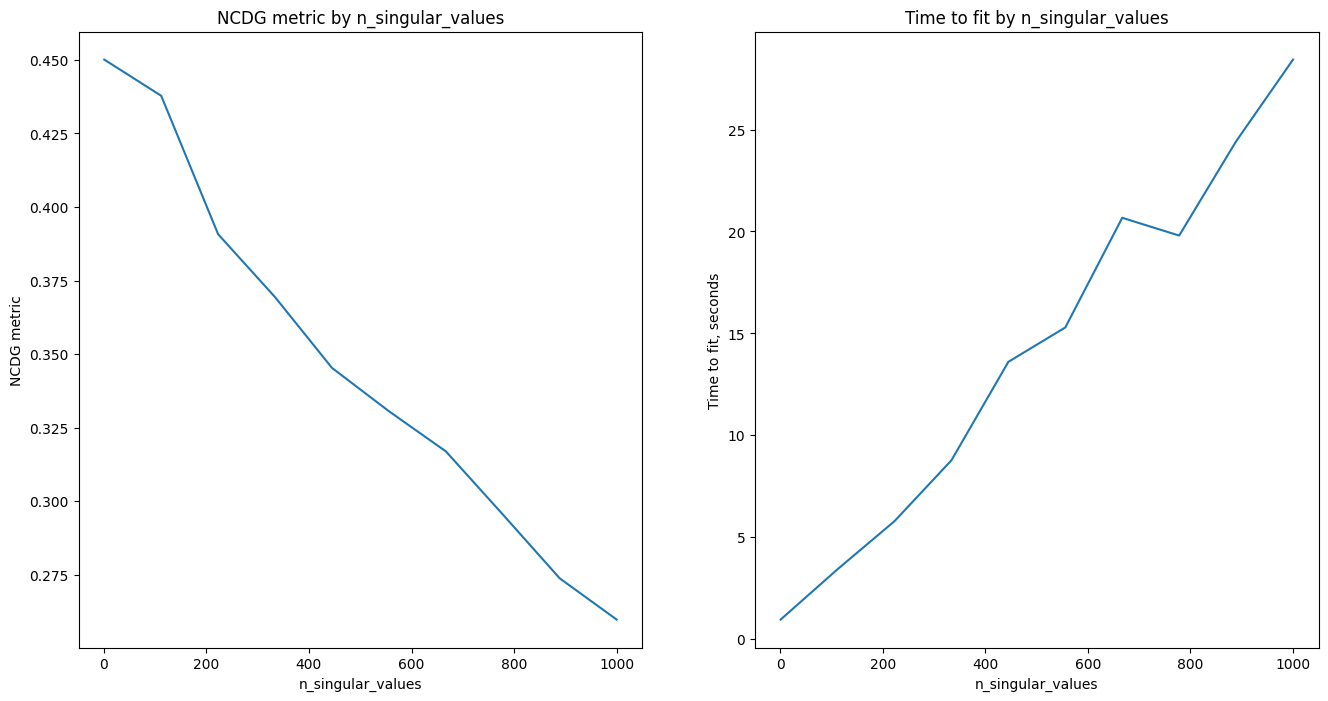

CPU times: user 14min 49s, sys: 2min, total: 16min 49s
Wall time: 5min 40s


In [61]:
%%time
plot_graphs(df_to_coo(df_train), df_to_coo(df_test), top_k=100)

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [69]:
from implicit.cpu.als import AlternatingLeastSquares

In [115]:
def make_als_recommendations(
    interractions: Union[np.ndarray, coo_array], 
    top_k: int = 100, 
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    csr_matrix_interations = csr_matrix(interactions)

    als_model = AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        alpha=alpha
    )

    als_model.fit(
        csr_matrix_interations,
        show_progress=False
    )
    
    recs = als_model.recommend(
        np.arange(csr_matrix_interations.shape[0]),
        csr_matrix_interations,
        N=top_k
    )
    
    return recs[0]

In [76]:
recs = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

In [83]:
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

In [93]:
%%time 

params_grid = ParameterGrid(
    {
        'n_factors': np.round(np.linspace(10, 250, 5)).astype(int),
        'alpha': np.linspace(.5, 2, 5),
        'regularization': np.linspace(1e-3, 1, 5),
    }
)

res = []

for cur_params in tqdm(params_grid):
    recs = make_als_recommendations(
        df_to_coo(df_train), 
        **cur_params
    )
    ndcg_score = ndcg_metric(
        df_to_coo(df_test), 
        recs
    )

    res.append(ndcg_score)

    print(f'{ndcg_score} score on {cur_params}')


%|                                                   | 0/125 [00:00<?, ?it/s]
%|▎                                          | 1/125 [00:21<44:43, 21.64s/it]

0.4729913691041731 score on {'alpha': 0.5, 'n_factors': 10, 'regularization': 0.001}



%|▋                                          | 2/125 [00:43<44:14, 21.58s/it]

0.4707503226268187 score on {'alpha': 0.5, 'n_factors': 10, 'regularization': 0.25075}



%|█                                          | 3/125 [01:04<43:56, 21.61s/it]

0.4716458151010804 score on {'alpha': 0.5, 'n_factors': 10, 'regularization': 0.5005}



%|█▍                                         | 4/125 [01:26<43:49, 21.73s/it]

0.4705213378957203 score on {'alpha': 0.5, 'n_factors': 10, 'regularization': 0.75025}



%|█▋                                         | 5/125 [01:48<43:21, 21.68s/it]

0.47069303369835613 score on {'alpha': 0.5, 'n_factors': 10, 'regularization': 1.0}



%|██                                         | 6/125 [02:12<44:34, 22.48s/it]

0.4491067981257153 score on {'alpha': 0.5, 'n_factors': 70, 'regularization': 0.001}



%|██▍                                        | 7/125 [02:36<45:09, 22.96s/it]

0.44933719636036284 score on {'alpha': 0.5, 'n_factors': 70, 'regularization': 0.25075}



%|██▊                                        | 8/125 [03:00<45:39, 23.41s/it]

0.44828733488404604 score on {'alpha': 0.5, 'n_factors': 70, 'regularization': 0.5005}



%|███                                        | 9/125 [03:24<45:44, 23.66s/it]

0.451526978003269 score on {'alpha': 0.5, 'n_factors': 70, 'regularization': 0.75025}



%|███▎                                      | 10/125 [03:49<45:45, 23.88s/it]

0.4487973074959741 score on {'alpha': 0.5, 'n_factors': 70, 'regularization': 1.0}



%|███▋                                      | 11/125 [04:16<47:27, 24.97s/it]

0.42818804313236286 score on {'alpha': 0.5, 'n_factors': 130, 'regularization': 0.001}



%|████                                      | 12/125 [04:44<48:28, 25.74s/it]

0.4293687759349351 score on {'alpha': 0.5, 'n_factors': 130, 'regularization': 0.25075}



%|████▎                                     | 13/125 [05:11<49:00, 26.26s/it]

0.4273476884672879 score on {'alpha': 0.5, 'n_factors': 130, 'regularization': 0.5005}



%|████▋                                     | 14/125 [05:39<49:16, 26.63s/it]

0.42828399289302216 score on {'alpha': 0.5, 'n_factors': 130, 'regularization': 0.75025}



%|█████                                     | 15/125 [06:06<49:17, 26.88s/it]

0.4272897299577087 score on {'alpha': 0.5, 'n_factors': 130, 'regularization': 1.0}



%|█████▍                                    | 16/125 [06:43<54:09, 29.81s/it]

0.4085109109470219 score on {'alpha': 0.5, 'n_factors': 190, 'regularization': 0.001}



%|█████▋                                    | 17/125 [07:19<57:20, 31.86s/it]

0.4078814882528472 score on {'alpha': 0.5, 'n_factors': 190, 'regularization': 0.25075}



%|██████                                    | 18/125 [07:56<59:26, 33.33s/it]

0.4067663651281792 score on {'alpha': 0.5, 'n_factors': 190, 'regularization': 0.5005}



%|██████                                  | 19/125 [08:33<1:00:43, 34.38s/it]

0.4076354440588907 score on {'alpha': 0.5, 'n_factors': 190, 'regularization': 0.75025}



%|██████▍                                 | 20/125 [09:09<1:01:18, 35.04s/it]

0.4081291734562758 score on {'alpha': 0.5, 'n_factors': 190, 'regularization': 1.0}



%|██████▋                                 | 21/125 [10:04<1:10:55, 40.92s/it]

0.3913533787173913 score on {'alpha': 0.5, 'n_factors': 250, 'regularization': 0.001}



%|███████                                 | 22/125 [10:59<1:17:13, 44.98s/it]

0.389340148079399 score on {'alpha': 0.5, 'n_factors': 250, 'regularization': 0.25075}



%|███████▎                                | 23/125 [11:55<1:22:27, 48.50s/it]

0.39009581708801316 score on {'alpha': 0.5, 'n_factors': 250, 'regularization': 0.5005}



%|███████▋                                | 24/125 [12:50<1:24:42, 50.32s/it]

0.3898426833777125 score on {'alpha': 0.5, 'n_factors': 250, 'regularization': 0.75025}



%|████████                                | 25/125 [13:43<1:25:30, 51.31s/it]

0.39072993542099355 score on {'alpha': 0.5, 'n_factors': 250, 'regularization': 1.0}



%|████████▎                               | 26/125 [14:05<1:10:01, 42.44s/it]

0.46844732436242437 score on {'alpha': 0.875, 'n_factors': 10, 'regularization': 0.001}



%|█████████                                 | 27/125 [14:27<59:11, 36.24s/it]

0.47185388937525563 score on {'alpha': 0.875, 'n_factors': 10, 'regularization': 0.25075}



%|█████████▍                                | 28/125 [14:49<51:41, 31.98s/it]

0.4679081485625859 score on {'alpha': 0.875, 'n_factors': 10, 'regularization': 0.5005}



%|█████████▋                                | 29/125 [15:11<46:25, 29.01s/it]

0.46900714029096824 score on {'alpha': 0.875, 'n_factors': 10, 'regularization': 0.75025}



%|██████████                                | 30/125 [15:33<42:32, 26.87s/it]

0.4690460492971774 score on {'alpha': 0.875, 'n_factors': 10, 'regularization': 1.0}



%|██████████▍                               | 31/125 [15:57<40:52, 26.10s/it]

0.4480797300650701 score on {'alpha': 0.875, 'n_factors': 70, 'regularization': 0.001}



%|██████████▊                               | 32/125 [16:21<39:34, 25.53s/it]

0.44704073418750084 score on {'alpha': 0.875, 'n_factors': 70, 'regularization': 0.25075}



%|███████████                               | 33/125 [16:46<38:36, 25.18s/it]

0.4481619656383471 score on {'alpha': 0.875, 'n_factors': 70, 'regularization': 0.5005}



%|███████████▍                              | 34/125 [17:10<37:42, 24.87s/it]

0.44760727746713264 score on {'alpha': 0.875, 'n_factors': 70, 'regularization': 0.75025}



%|███████████▊                              | 35/125 [17:34<36:57, 24.63s/it]

0.4465596698072831 score on {'alpha': 0.875, 'n_factors': 70, 'regularization': 1.0}



%|████████████                              | 36/125 [18:02<37:53, 25.55s/it]

0.4288310714608974 score on {'alpha': 0.875, 'n_factors': 130, 'regularization': 0.001}



%|████████████▍                             | 37/125 [18:29<38:21, 26.16s/it]

0.42543800726265496 score on {'alpha': 0.875, 'n_factors': 130, 'regularization': 0.25075}



%|████████████▊                             | 38/125 [18:57<38:28, 26.53s/it]

0.4293739043688771 score on {'alpha': 0.875, 'n_factors': 130, 'regularization': 0.5005}



%|█████████████                             | 39/125 [19:24<38:24, 26.79s/it]

0.4268411378664931 score on {'alpha': 0.875, 'n_factors': 130, 'regularization': 0.75025}



%|█████████████▍                            | 40/125 [19:52<38:13, 26.98s/it]

0.42637858067962897 score on {'alpha': 0.875, 'n_factors': 130, 'regularization': 1.0}



%|█████████████▊                            | 41/125 [20:29<42:01, 30.02s/it]

0.4101092689745943 score on {'alpha': 0.875, 'n_factors': 190, 'regularization': 0.001}



%|██████████████                            | 42/125 [21:05<44:20, 32.05s/it]

0.41115716547459186 score on {'alpha': 0.875, 'n_factors': 190, 'regularization': 0.25075}



%|██████████████▍                           | 43/125 [21:42<45:47, 33.51s/it]

0.4074452959989248 score on {'alpha': 0.875, 'n_factors': 190, 'regularization': 0.5005}



%|██████████████▊                           | 44/125 [22:19<46:35, 34.52s/it]

0.4075421422627357 score on {'alpha': 0.875, 'n_factors': 190, 'regularization': 0.75025}



%|███████████████                           | 45/125 [22:56<46:58, 35.24s/it]

0.40904431678180403 score on {'alpha': 0.875, 'n_factors': 190, 'regularization': 1.0}



%|███████████████▍                          | 46/125 [23:50<53:42, 40.79s/it]

0.389824964162452 score on {'alpha': 0.875, 'n_factors': 250, 'regularization': 0.001}



%|███████████████▊                          | 47/125 [24:44<58:10, 44.75s/it]

0.39245627602157596 score on {'alpha': 0.875, 'n_factors': 250, 'regularization': 0.25075}



%|███████████████▎                        | 48/125 [25:38<1:00:57, 47.50s/it]

0.3964551108313504 score on {'alpha': 0.875, 'n_factors': 250, 'regularization': 0.5005}



%|███████████████▋                        | 49/125 [26:33<1:02:57, 49.70s/it]

0.39347825154423655 score on {'alpha': 0.875, 'n_factors': 250, 'regularization': 0.75025}



%|████████████████                        | 50/125 [27:26<1:03:35, 50.88s/it]

0.39057665824417576 score on {'alpha': 0.875, 'n_factors': 250, 'regularization': 1.0}



%|█████████████████▏                        | 51/125 [27:48<51:59, 42.15s/it]

0.46806311350424523 score on {'alpha': 1.25, 'n_factors': 10, 'regularization': 0.001}



%|█████████████████▍                        | 52/125 [28:10<43:49, 36.02s/it]

0.46594974887611346 score on {'alpha': 1.25, 'n_factors': 10, 'regularization': 0.25075}



%|█████████████████▊                        | 53/125 [28:32<38:05, 31.75s/it]

0.46673485062498943 score on {'alpha': 1.25, 'n_factors': 10, 'regularization': 0.5005}



%|██████████████████▏                       | 54/125 [28:53<34:03, 28.79s/it]

0.46932715309630857 score on {'alpha': 1.25, 'n_factors': 10, 'regularization': 0.75025}



%|██████████████████▍                       | 55/125 [29:15<31:08, 26.70s/it]

0.46716869557953067 score on {'alpha': 1.25, 'n_factors': 10, 'regularization': 1.0}



%|██████████████████▊                       | 56/125 [29:39<29:50, 25.95s/it]

0.4428574755930504 score on {'alpha': 1.25, 'n_factors': 70, 'regularization': 0.001}



%|███████████████████▏                      | 57/125 [30:04<28:47, 25.40s/it]

0.44166039756524683 score on {'alpha': 1.25, 'n_factors': 70, 'regularization': 0.25075}



%|███████████████████▍                      | 58/125 [30:28<28:02, 25.11s/it]

0.4442286755111758 score on {'alpha': 1.25, 'n_factors': 70, 'regularization': 0.5005}



%|███████████████████▊                      | 59/125 [30:52<27:17, 24.81s/it]

0.44249010436437297 score on {'alpha': 1.25, 'n_factors': 70, 'regularization': 0.75025}



%|████████████████████▏                     | 60/125 [31:16<26:38, 24.60s/it]

0.44094882703297267 score on {'alpha': 1.25, 'n_factors': 70, 'regularization': 1.0}



%|████████████████████▍                     | 61/125 [31:44<27:09, 25.46s/it]

0.4249366928665917 score on {'alpha': 1.25, 'n_factors': 130, 'regularization': 0.001}



%|████████████████████▊                     | 62/125 [32:11<27:22, 26.07s/it]

0.4281911334197485 score on {'alpha': 1.25, 'n_factors': 130, 'regularization': 0.25075}



%|█████████████████████▏                    | 63/125 [32:39<27:23, 26.50s/it]

0.42544077389131996 score on {'alpha': 1.25, 'n_factors': 130, 'regularization': 0.5005}



%|█████████████████████▌                    | 64/125 [33:06<27:14, 26.80s/it]

0.4258353093442654 score on {'alpha': 1.25, 'n_factors': 130, 'regularization': 0.75025}



%|█████████████████████▊                    | 65/125 [33:34<26:59, 27.00s/it]

0.4265271782047941 score on {'alpha': 1.25, 'n_factors': 130, 'regularization': 1.0}



%|██████████████████████▏                   | 66/125 [34:10<29:26, 29.95s/it]

0.40604630788839646 score on {'alpha': 1.25, 'n_factors': 190, 'regularization': 0.001}



%|██████████████████████▌                   | 67/125 [34:47<30:54, 31.97s/it]

0.4115290271617729 score on {'alpha': 1.25, 'n_factors': 190, 'regularization': 0.25075}



%|██████████████████████▊                   | 68/125 [35:24<31:42, 33.37s/it]

0.40828207831307844 score on {'alpha': 1.25, 'n_factors': 190, 'regularization': 0.5005}



%|███████████████████████▏                  | 69/125 [36:00<32:03, 34.35s/it]

0.4113675927930134 score on {'alpha': 1.25, 'n_factors': 190, 'regularization': 0.75025}



%|███████████████████████▌                  | 70/125 [36:37<32:10, 35.09s/it]

0.412652863139968 score on {'alpha': 1.25, 'n_factors': 190, 'regularization': 1.0}



%|███████████████████████▊                  | 71/125 [37:36<37:51, 42.06s/it]

0.3926557917636986 score on {'alpha': 1.25, 'n_factors': 250, 'regularization': 0.001}



%|████████████████████████▏                 | 72/125 [38:34<41:31, 47.02s/it]

0.3940423079421393 score on {'alpha': 1.25, 'n_factors': 250, 'regularization': 0.25075}



%|████████████████████████▌                 | 73/125 [39:33<43:46, 50.51s/it]

0.3959458732874956 score on {'alpha': 1.25, 'n_factors': 250, 'regularization': 0.5005}



%|████████████████████████▊                 | 74/125 [40:32<45:02, 53.00s/it]

0.3957228718371061 score on {'alpha': 1.25, 'n_factors': 250, 'regularization': 0.75025}



%|█████████████████████████▏                | 75/125 [41:29<45:22, 54.45s/it]

0.3941792459704492 score on {'alpha': 1.25, 'n_factors': 250, 'regularization': 1.0}



%|█████████████████████████▌                | 76/125 [41:51<36:26, 44.63s/it]

0.4656330935051608 score on {'alpha': 1.625, 'n_factors': 10, 'regularization': 0.001}



%|█████████████████████████▊                | 77/125 [42:13<30:12, 37.77s/it]

0.46639063978206835 score on {'alpha': 1.625, 'n_factors': 10, 'regularization': 0.25075}



%|██████████████████████████▏               | 78/125 [42:35<25:48, 32.95s/it]

0.46510284426237863 score on {'alpha': 1.625, 'n_factors': 10, 'regularization': 0.5005}



%|██████████████████████████▌               | 79/125 [42:57<22:45, 29.69s/it]

0.46558414959173505 score on {'alpha': 1.625, 'n_factors': 10, 'regularization': 0.75025}



%|██████████████████████████▉               | 80/125 [43:18<20:28, 27.30s/it]

0.4657578563337493 score on {'alpha': 1.625, 'n_factors': 10, 'regularization': 1.0}



%|███████████████████████████▏              | 81/125 [43:43<19:19, 26.36s/it]

0.4387769692059617 score on {'alpha': 1.625, 'n_factors': 70, 'regularization': 0.001}



%|███████████████████████████▌              | 82/125 [44:07<18:25, 25.72s/it]

0.4375043308180811 score on {'alpha': 1.625, 'n_factors': 70, 'regularization': 0.25075}



%|███████████████████████████▉              | 83/125 [44:31<17:43, 25.32s/it]

0.439133979853723 score on {'alpha': 1.625, 'n_factors': 70, 'regularization': 0.5005}



%|████████████████████████████▏             | 84/125 [44:55<17:03, 24.97s/it]

0.43957405113314785 score on {'alpha': 1.625, 'n_factors': 70, 'regularization': 0.75025}



%|████████████████████████████▌             | 85/125 [45:20<16:30, 24.76s/it]

0.4407675929192969 score on {'alpha': 1.625, 'n_factors': 70, 'regularization': 1.0}



%|████████████████████████████▉             | 86/125 [45:47<16:37, 25.57s/it]

0.4226249865089336 score on {'alpha': 1.625, 'n_factors': 130, 'regularization': 0.001}



%|█████████████████████████████▏            | 87/125 [46:15<16:32, 26.13s/it]

0.4246780791023481 score on {'alpha': 1.625, 'n_factors': 130, 'regularization': 0.25075}



%|█████████████████████████████▌            | 88/125 [46:42<16:21, 26.53s/it]

0.42460577626658497 score on {'alpha': 1.625, 'n_factors': 130, 'regularization': 0.5005}



%|█████████████████████████████▉            | 89/125 [47:10<16:05, 26.83s/it]

0.42350533321292866 score on {'alpha': 1.625, 'n_factors': 130, 'regularization': 0.75025}



%|██████████████████████████████▏           | 90/125 [47:37<15:45, 27.01s/it]

0.420241792582272 score on {'alpha': 1.625, 'n_factors': 130, 'regularization': 1.0}



%|██████████████████████████████▌           | 91/125 [48:14<16:59, 29.97s/it]

0.4060263735603204 score on {'alpha': 1.625, 'n_factors': 190, 'regularization': 0.001}



%|██████████████████████████████▉           | 92/125 [48:51<17:36, 32.01s/it]

0.41546382131315085 score on {'alpha': 1.625, 'n_factors': 190, 'regularization': 0.25075}



%|███████████████████████████████▏          | 93/125 [49:27<17:48, 33.40s/it]

0.40867921089582404 score on {'alpha': 1.625, 'n_factors': 190, 'regularization': 0.5005}



%|███████████████████████████████▌          | 94/125 [50:04<17:45, 34.38s/it]

0.4087791317825157 score on {'alpha': 1.625, 'n_factors': 190, 'regularization': 0.75025}



%|███████████████████████████████▉          | 95/125 [50:41<17:32, 35.09s/it]

0.40640296808178794 score on {'alpha': 1.625, 'n_factors': 190, 'regularization': 1.0}



%|████████████████████████████████▎         | 96/125 [51:41<20:39, 42.73s/it]

0.3965375008614821 score on {'alpha': 1.625, 'n_factors': 250, 'regularization': 0.001}



%|████████████████████████████████▌         | 97/125 [52:40<22:11, 47.55s/it]

0.39846734459220184 score on {'alpha': 1.625, 'n_factors': 250, 'regularization': 0.25075}



%|████████████████████████████████▉         | 98/125 [53:39<22:52, 50.83s/it]

0.3998557760293172 score on {'alpha': 1.625, 'n_factors': 250, 'regularization': 0.5005}



%|█████████████████████████████████▎        | 99/125 [54:36<22:56, 52.95s/it]

0.3951563289931877 score on {'alpha': 1.625, 'n_factors': 250, 'regularization': 0.75025}



%|████████████████████████████████▊        | 100/125 [55:35<22:48, 54.75s/it]

0.3963478872249238 score on {'alpha': 1.625, 'n_factors': 250, 'regularization': 1.0}



%|█████████████████████████████████▏       | 101/125 [55:57<17:56, 44.86s/it]

0.46283499410723883 score on {'alpha': 2.0, 'n_factors': 10, 'regularization': 0.001}



%|█████████████████████████████████▍       | 102/125 [56:19<14:32, 37.95s/it]

0.46408134654465993 score on {'alpha': 2.0, 'n_factors': 10, 'regularization': 0.25075}



%|█████████████████████████████████▊       | 103/125 [56:41<12:07, 33.08s/it]

0.4635826049513776 score on {'alpha': 2.0, 'n_factors': 10, 'regularization': 0.5005}



%|██████████████████████████████████       | 104/125 [57:03<10:24, 29.76s/it]

0.465565615735731 score on {'alpha': 2.0, 'n_factors': 10, 'regularization': 0.75025}



%|██████████████████████████████████▍      | 105/125 [57:25<09:07, 27.36s/it]

0.46450517444721534 score on {'alpha': 2.0, 'n_factors': 10, 'regularization': 1.0}



%|██████████████████████████████████▊      | 106/125 [57:49<08:23, 26.48s/it]

0.43881638252321636 score on {'alpha': 2.0, 'n_factors': 70, 'regularization': 0.001}



%|███████████████████████████████████      | 107/125 [58:14<07:47, 25.96s/it]

0.4368654063098494 score on {'alpha': 2.0, 'n_factors': 70, 'regularization': 0.25075}



%|███████████████████████████████████▍     | 108/125 [58:38<07:13, 25.49s/it]

0.43441296722063605 score on {'alpha': 2.0, 'n_factors': 70, 'regularization': 0.5005}



%|███████████████████████████████████▊     | 109/125 [59:02<06:42, 25.14s/it]

0.4322404092313325 score on {'alpha': 2.0, 'n_factors': 70, 'regularization': 0.75025}



%|████████████████████████████████████     | 110/125 [59:27<06:13, 24.87s/it]

0.43506292637409055 score on {'alpha': 2.0, 'n_factors': 70, 'regularization': 1.0}



%|████████████████████████████████████▍    | 111/125 [59:54<05:58, 25.64s/it]

0.41766489702864495 score on {'alpha': 2.0, 'n_factors': 130, 'regularization': 0.001}



%|██████████████████████████████████▉    | 112/125 [1:00:22<05:41, 26.25s/it]

0.4210413019969284 score on {'alpha': 2.0, 'n_factors': 130, 'regularization': 0.25075}



%|███████████████████████████████████▎   | 113/125 [1:00:49<05:19, 26.65s/it]

0.4178690941289194 score on {'alpha': 2.0, 'n_factors': 130, 'regularization': 0.5005}



%|███████████████████████████████████▌   | 114/125 [1:01:17<04:56, 26.93s/it]

0.423238432468677 score on {'alpha': 2.0, 'n_factors': 130, 'regularization': 0.75025}



%|███████████████████████████████████▉   | 115/125 [1:01:44<04:30, 27.08s/it]

0.42196809509278876 score on {'alpha': 2.0, 'n_factors': 130, 'regularization': 1.0}



%|████████████████████████████████████▏  | 116/125 [1:02:21<04:29, 29.99s/it]

0.40404602335850515 score on {'alpha': 2.0, 'n_factors': 190, 'regularization': 0.001}



%|████████████████████████████████████▌  | 117/125 [1:02:58<04:16, 32.05s/it]

0.4105420963331314 score on {'alpha': 2.0, 'n_factors': 190, 'regularization': 0.25075}



%|████████████████████████████████████▊  | 118/125 [1:03:35<03:54, 33.51s/it]

0.40892588704868554 score on {'alpha': 2.0, 'n_factors': 190, 'regularization': 0.5005}



%|█████████████████████████████████████▏ | 119/125 [1:04:12<03:26, 34.47s/it]

0.4113563978693621 score on {'alpha': 2.0, 'n_factors': 190, 'regularization': 0.75025}



%|█████████████████████████████████████▍ | 120/125 [1:04:48<02:55, 35.13s/it]

0.40737623295096775 score on {'alpha': 2.0, 'n_factors': 190, 'regularization': 1.0}



%|█████████████████████████████████████▊ | 121/125 [1:05:42<02:42, 40.74s/it]

0.3901405354058014 score on {'alpha': 2.0, 'n_factors': 250, 'regularization': 0.001}



%|██████████████████████████████████████ | 122/125 [1:06:36<02:14, 44.80s/it]

0.39514009402126915 score on {'alpha': 2.0, 'n_factors': 250, 'regularization': 0.25075}



%|██████████████████████████████████████▍| 123/125 [1:07:31<01:35, 47.84s/it]

0.39561698172943693 score on {'alpha': 2.0, 'n_factors': 250, 'regularization': 0.5005}



%|██████████████████████████████████████▋| 124/125 [1:08:25<00:49, 49.61s/it]

0.39784668207441193 score on {'alpha': 2.0, 'n_factors': 250, 'regularization': 0.75025}



100%|███████████████████████████████████████| 125/125 [1:09:25<00:00, 33.32s/it]

0.3925996063166551 score on {'alpha': 2.0, 'n_factors': 250, 'regularization': 1.0}
CPU times: user 2h 59min 43s, sys: 35min 6s, total: 3h 34min 49s
Wall time: 1h 9min 25s


Наилучший скор -- `0.4707503226268187 score on {'alpha': 0.5, 'n_factors': 10, 'regularization': 0.25075}`:

In [95]:
np.argmax(res) + 1

1

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [100]:
movies = pd.read_csv(
    "ml-1m/movies.dat", 
    sep='::', 
    names=['id', 'title', 'genres'], 
    engine='python', 
    encoding='cp1250', 
    index_col=0
)

id_mov_dict = movies.title.to_dict()

In [103]:
model = AlternatingLeastSquares(**{'alpha': 0.5, 'factors': 10, 'regularization': 0.25075})

In [105]:
model.fit(
    csr_matrix(interactions),
    show_progress=False
)

In [109]:
%%time

recs_dict = {}
topn = 3

for user_id in np.random.choice(csr_matrix(interactions).shape[0], 10):
    recs_dict[user_id] = {}
    for rec_item in recs[user_id,:topn]:
        model_explanation = [movie[0] for movie in model.explain(user_id, csr_matrix(interactions), rec_item, N=topn)[1]]
        movies_lst = [id_mov_dict[movie] for movie in item_le.inverse_transform(model_explanation)]
        recs_dict[user_id][id_mov_dict[item_le.inverse_transform([rec_item])[0]]] = movies_lst

CPU times: user 2.69 s, sys: 107 ms, total: 2.8 s
Wall time: 2.81 s


Взяли 5 случайных юзеров и получили топ-3 рекомендации по фильмам:

In [110]:
recs_dict

{4584: {'Crumb (1994)': ['Rushmore (1998)',
   'Roger & Me (1989)',
   'Lone Star (1996)'],
  'Little Big Man (1970)': ['Maltese Falcon, The (1941)',
   'African Queen, The (1951)',
   'Diner (1982)'],
  'Raging Bull (1980)': ['Apocalypse Now (1979)',
   'Godfather: Part II, The (1974)',
   'GoodFellas (1990)']},
 1677: {'Terminator 2: Judgment Day (1991)': ['Star Wars: Episode IV - A New Hope (1977)',
   'Matrix, The (1999)',
   'Jurassic Park (1993)'],
  'Being John Malkovich (1999)': ['American Beauty (1999)',
   'Clerks (1994)',
   'Shakespeare in Love (1998)'],
  'Contact (1997)': ['Matrix, The (1999)',
   'E.T. the Extra-Terrestrial (1982)',
   'Total Recall (1990)']},
 957: {'Rock, The (1996)': ['Air Force One (1997)',
   'Fugitive, The (1993)',
   'Clear and Present Danger (1994)'],
  'Die Hard 2 (1990)': ['Air Force One (1997)',
   'Die Hard: With a Vengeance (1995)',
   'Heat (1995)'],
  'Matrix, The (1999)': ['Terminator 2: Judgment Day (1991)',
   'Total Recall (1990)',
   

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

1)

In [116]:
%%time

svd_pred = make_svd_recommendations(
    np.where(interactions > 0, 1, 0),  # interactions == тестовая выборка
    n_singular_values=7, 
    top_k=100
)
ials_pred = make_als_recommendations(
    np.where(interactions > 0, 1, 0), 
    top_k=100, 
    **{'alpha': 0.5, 'n_factors': 10, 'regularization': 0.25075}
)

CPU times: user 2min 16s, sys: 14.7 s, total: 2min 31s
Wall time: 24.2 s


In [117]:
ndcg_metric(df_to_coo(df_test), svd_pred).mean(), ndcg_metric(df_to_coo(df_test), ials_pred).mean()

(0.4855949019149442, 0.47019648616965615)

2)

In [118]:
%%time

svd_pred = make_svd_recommendations(
    np.where(interactions > 3, 1, 0), 
    n_singular_values=7, 
    top_k=100
)
ials_pred = make_als_recommendations(
    np.where(interactions > 3, 1, 0), 
    top_k=100, 
    **{'alpha': 0.5, 'n_factors': 10, 'regularization': 0.25075}
)

CPU times: user 2min 5s, sys: 12.2 s, total: 2min 18s
Wall time: 21.3 s


In [119]:
ndcg_metric(df_to_coo(df_test), svd_pred).mean(), ndcg_metric(df_to_coo(df_test), ials_pred).mean()

(0.43408112443449653, 0.47135327063844523)

3)

In [120]:
%%time

svd_pred = make_svd_recommendations(
    np.where(interactions > 3, 1, np.where(interactions == 0, 0, -1)), 
    n_singular_values=7, 
    top_k=100
)
ials_pred = make_als_recommendations(
    np.where(interactions > 3, 1, np.where(interactions == 0, 0, -1)), 
    top_k=100, 
    **{'alpha': 0.5, 'n_factors': 10, 'regularization': 0.25075}
)

CPU times: user 2min 24s, sys: 15.4 s, total: 2min 40s
Wall time: 26.8 s


In [121]:
ndcg_metric(df_to_coo(df_test), svd_pred).mean(), ndcg_metric(df_to_coo(df_test), ials_pred).mean()

(0.4855949019149442, 0.4703018695886516)

4)

In [127]:
mnth_array = df_train.datetime.apply(lambda x: x.month + (x.year * 12))
smoothing_coefs = (mnth_array.max() + 1) - mnth_array

In [129]:
smoothing_matrix = np.ones(interactions.shape)
smoothing_matrix[df_train.user_id.values, df_train.item_id.values] = smoothing_coefs

In [130]:
%%time

svd_pred = make_svd_recommendations(
    np.where(interactions > 3, 1, np.where(interactions == 0, 0, -1)) / smoothing_matrix, 
    n_singular_values=7, 
    top_k=100
)
ials_pred = make_als_recommendations(
    np.where(interactions > 3, 1, np.where(interactions == 0, 0, -1)) / smoothing_matrix, 
    top_k=100, 
    **{'alpha': 0.5, 'n_factors': 10, 'regularization': 0.25075}
)

CPU times: user 2min 7s, sys: 14.2 s, total: 2min 21s
Wall time: 22.2 s


In [131]:
ndcg_metric(df_to_coo(df_test), svd_pred).mean(), ndcg_metric(df_to_coo(df_test), ials_pred).mean()

(0.4855949019149442, 0.4701888198506908)

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [ ]:
class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef = 0.01):
        #your code here

    def fit(self, interractions: np.ndarray, n_iterations: int 10):
        #your code here

    def predict(self, top_k: int = 100):
        # возвращает top-k айтемов для каждого юзера(айтемы с которыми юзер взаимодействовал не должны попасть в рекомендации)
        #your code here

        return predicts # shape ~ [n_users, top_k]